In [0]:
!pip3 install pyshp
!pip3 install geopandas
!pip3 install OWSLib
!pip3 install zipfile
!pip3 install opencv-python
!pip3 install imageio
!pip3 install tensorflow
!pip3 install pickle
!pip3 install utils
!pip3 install cnn_models

ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
ERROR: Could not find a version that satisfies the requirement cnn_models (from versions: none)
ERROR: No matching distribution found for cnn_models


# New Section

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import imageio

import shapefile as shp
import json
import geopandas as gpd
import datetime
from owslib.wms import WebMapService

import zipfile
from collections import defaultdict
import cv2
!pwd

/content


in the tutorial, the author gets the sattellite image data from the Dutch government open data portal. However, the data has been moved, and I got the rest of the data from the dropbox. I cannot get the satellite image data, so I just used his image tiles, but I know what he is doing. Now we will have to unzip our zipfiles containing the images and shapefiles:

In [0]:
#!mkdir shapefile-new
#!mkdir shapefile-new/2017_09
#!mkdir image_tiles

#extracting the shapefiles
#zip_ref = zipfile.ZipFile('2017_09.zip')
#zip_ref.extractall('shapefile')

#extracting the image tiles
#zip_ref = zipfile.ZipFile('image_tiles_200.zip')
#zip_ref.extractall('image_tiles')

###here we define the BOUNDING_BOX, or region where we would like to visualize###

x_min = 100000 #min x-val (start in our coordinate)
y_min = 427000 #min y-val
dx, dy = 200, 200 #(the amount of x and y we would want stored from the map in each tile)

no_tiles_x = 100 #number of tiles on the grid over the image
no_tiles_y = 100 #total tiles we make is image_width = 256
image_height = 256
image_depth = 3
total_no_images = 10000
 
x_max = x_min + no_tiles_x * dx #max x-val (end in our coordinates)
y_max = y_min + no_tiles_y * dy #max y-val 

BOUNDING_BOX = [x_min, y_min, x_max, y_max] #this is the important global variable we wanted



We extracted the zipfiles now. let's read our shapefile and convert its contents into a json so we do not have to repeat the shapefile-reading process each time:

In [0]:
filename ='shapefile-new/2017_09/Wegvakken.shp'
gdf = gpd.read_file(filename)
gdf.to_file("gpd_output.json", driver='GeoJSON')
#WOW SAVED SO MUCH MEMORY

In [0]:
gdf.to_file("gpd_output.json", driver='GeoJSON')

# Mapping the layers now. We want to determine which image tiles have roads, and which do not:

let's go and define the road types with some variables, whether they are municpality(Gemeente), government(Rijik), etc. We wil also indicate the road color types aswell. I am also writing some keys to get

In [0]:
####### MAPPING TIME ##########
#let's define some important keys first
#First we define some variables, and dictionary keys which are going to be used throughout the rest.

dict_roadtype = {              #THIS ISN'T NEEDED SO LET'S SAVE MEMORY (but I do like statistics so I'll keep it)
    "G": 'Gemeente',
    "R": 'Rijk',
    "P": 'Provincie',
    "W": 'Waterschap',
    'T': 'Andere wegbeheerder',
    '' : 'leeg'
}

dict_roadtype_to_color = {
    "G": 'red',
    "R": 'blue',
    "P": 'green',
    "W": 'magenta',
    'T': 'yellow',
    '' : 'leeg'
}

FEATURES_KEY = "features"
PROPERTIES_KEY = "properties"
GEOMETRY_KEY = "geometry"
COORDINATES_KEY = "coordinates"
WEGSOORT_KEY = "WEGBEHSRT"

MINIMUM_NO_POINTS_PER_TILE = 4
POINTS_PER_METER = 0.1

INPUT_FOLDER_TILES = 'image_tiles/image_tiles_200/'


filename_wegvakken = "gpd_output.json"
gpd_json = json.load(open(filename_wegvakken))

dict_features = gpd_json[FEATURES_KEY] #get all the json data
dict_tile_contents = defaultdict(list) #stores tiles to their contents (key:tilename, value:list)
dict_roadtype_tiles = defaultdict(set) # stores road-type as its keys and the tiles that have the road type as its value (key:roadttype value:set)


In [0]:
print(dict_features)

now that we created  our keys and an our dictionaries, I will create some helper functions from the tutorial that will help us work with this data:

In [0]:
INPUT_FOLDER_TILES = 'image_tiles/image_tiles_200/'

In [0]:
def coord_is_in_bb(coord, bb): #check wheter the coordniate is inside the bounding box (bb)
    x_min = bb[0]
    y_min = bb[1]
    x_max = bb[2]
    y_max = bb[3]
    return ((coord[0] >= x_min) and (coord[0] <= x_max) and (coord[1] >= y_min) and (coord[1] <= y_max)) #return true if x-min < x-coord < x-max and y-min < y-coord < y-max 
 
def get_intermediate_coords(coord1, coord2, num_points):
    dx = (coord2[0] - coord1[0])/(num_points + 1) #we add 1 because we want to space between coord2's points and the last intermediate point
    dy = (coord2[1] - coord1[1])/(num_points + 1)
    return [[coord1[0] + i*dx, coord1[1] + i*dy] for i in range (0, (num_points+1))]


def retrieve_roadtype(elem): #get the roadtype value from a particular line geometry
    return elem[PROPERTIES_KEY][WEGSOORT_KEY]
   
def retrieve_coordinates(elem): #get coordinate value
    return elem[GEOMETRY_KEY][COORDINATES_KEY]
  
 
def add_to_dict(d1, d2, coordinate, rtype): #get a tile based on the given coordinate
    coordinate_ll_x = int((coordinate[0] // dx)*dx) #get lower x of the tile containing the coordinate by doing division with the dx and truncating down then multiplying that by dx
    coordinate_ll_y = int((coordinate[1] // dy)*dy) #get lower y of tile by division(trunacte donw) with dy then multiplying that by dy
    coordinate_ur_x = int((coordinate[0] // dx)*dx + dx) #get upper x by getting lower x and adding dx
    coordinate_ur_y = int((coordinate[1] // dy)*dy + dy) #get upper y by getting lower y then adding dy
    tile = "{}_{}_{}_{}.jpg".format(coordinate_ll_x, coordinate_ll_y, coordinate_ur_x, coordinate_ur_y)
    
    rel_coord_x = (coordinates[0] - coordinate_ll_x) / dx #relative coordinates
    rel_coord_y = (coordinates[1] - coordinate_ll_y) / dy
    value = (rtype, rel_coord_x, rel_coord_y)
    d1[tile].append(value)  #for the tile dictionary, we are storing the tile to map with its roadtype with the roadtype's relative coordinates on the tile
    
    d2[rtype].add(tile) #roadtype will get a new tile added with it This is for statistics only

now let's do our data processing

In [0]:
for elem in dict_features: #iterate through each geometry
  coordinates = retrieve_coordinates(elem) #get the coordinates of the road
  road_type = retrieve_roadtype(elem)
  coordinates_in_bbox = [coord for coord in coordinates if coord_is_in_bb(coord, BOUNDING_BOX)] #see which coordinates of the linestr geometry are within bounding box
  
  if len(coordinates_in_bbox) == 1: #only one coordinate is in bounding box
    add_to_dict(dict_tile_contents, dict_roadtype_tiles, coord, road_type) #add the coordinate with the roadtype to tiles_dict, add the tile do the roadtype given
    
  if len(coordinates_in_bbox) > 1:
    add_to_dict(dict_tile_contents, dict_roadtype_tiles, coordinates_in_bbox[0], road_type)#add part one
    for ii in range(1, len(coordinates_in_bbox)): #loop through each coordinate
      prev_coord = coordinates_in_bbox[ii-1]
      coord = coordinates_in_bbox[ii]
      add_to_dict(dict_tile_contents, dict_roadtype_tiles, coord, road_type)
      
      dist = np.linalg.norm(np.array(coord)-np.array(prev_coord))
      no_intermediates = int(dist/10) #get the number of intermediate points in between two points
      
      intermediate_coords = get_intermediate_coords(prev_coord, coord, no_intermediates)
      
      for coord in intermediate_coords:
        add_to_dict(dict_tile_contents, dict_roadtype_tiles, coord, road_type)

Time to visualize everything now that we got our data prepared:

Now we processed the data. **time to visualize it on the map**







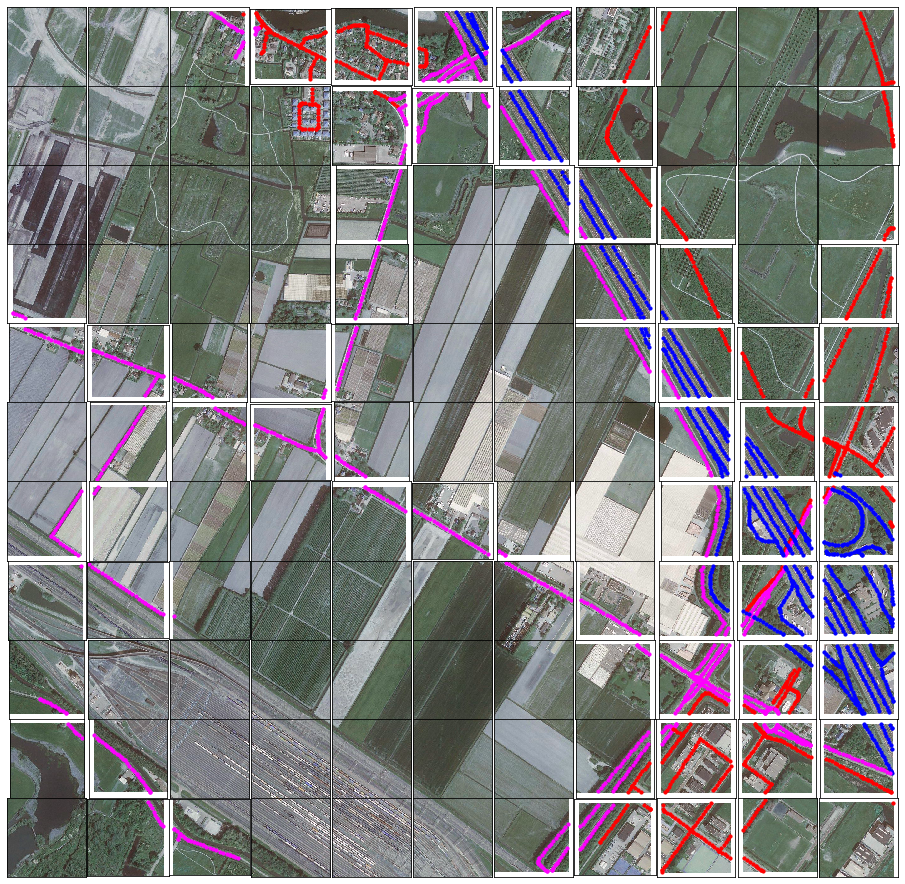

In [0]:
x0 = x_min
y0 = y_min
fig, axarr = plt.subplots(nrows=11, ncols=11, figsize=(16,16)) #we created 11 rows and 11 columns

for ii in range (0,11):
  for jj in range(0,11):
    ll_x = x0 + ii*dx
    ll_y = y0 + jj*dy
    ur_x = ll_x + dx
    ur_y = ll_y + dy
    tilename = '{}_{}_{}_{}.jpg'.format(ll_x, ll_y, ur_x, ur_y)
    filename = INPUT_FOLDER_TILES + tilename
    tile_contents = dict_tile_contents[tilename] #get the tile contents (array of tuples containing road type & relative coords of the road in that tile)

    
    ax = axarr[10-jj, ii]
    image = plt.imread(filename)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #convert our map to rgb
    ax.imshow(rgb_image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    for elem in tile_contents:
      
      color = dict_roadtype_to_color[elem[0]]
      x = elem[1]*256 #256 because that's the size of the image (and I need to convert relative distance in the tile to a point on the image)
      y = (1-elem[2]) *256
      ax.scatter(x,y, c=color, s=10)
      
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
  

And here we have a visualization of the roads.

# Neural Network to detect the roads

In [0]:
#!mkdir cnn_models
!mv /*.py /content/cnn_models

In [0]:
import tensorflow as tf
import pickle #for streaming our data
from utils import *
from cnn_models.vggnet16 import * #see directory for more details

## Prepare the dataset

Now that we have imported our libraries, let's prepare the dataset first. We will start by creating some functions:

In [0]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

def onehot_encode_labels(labels):
    list_possible_labels = list(np.unique(labels))
    encoded_labels = map(lambda x: list_possible_labels.index(x), labels)
    return encoded_labels

def randomize(dataset, labels1, labels2, labels3):
    permutation = np.random.permutation(dataset.shape[0])
    randomized_dataset = dataset[permutation, :, :, :]
    randomized_labels1 = labels1[permutation]
    randomized_labels2 = labels2[permutation]
    randomized_labels3 = labels3[permutation]
    return randomized_dataset, randomized_labels1, randomized_labels2, randomized_labels3

def one_hot_encode(np_array, num_unique_labels): #for randomizing our dataset
    return (np.arange(num_unique_labels) == np_array[:,None]).astype(np.float32)

def reformat_data(dataset, labels1, labels2, labels3):
    dataset, labels1, labels2, labels3 = randomize(dataset, labels1, labels2, labels3)
    num_unique_labels1 = len(np.unique(labels1))
    num_unique_labels2 = len(np.unique(labels2))
    labels1 = one_hot_encode(labels1, num_unique_labels1)
    labels2 = one_hot_encode(labels2, num_unique_labels2)
    return dataset, labels1, labels2, labels3

time to prepare our dataset. We set this picture at 256x256, as this is standard. We also have 10,000 images to work with.

In [0]:
image_width = 256
image_height = 256
image_depth = 3
total_no_images = 10000

image_files = os.listdir(INPUT_FOLDER_FILES) #getting the directory of files

dataset = np.ndarray(shape=(total_no_images, image_width, image_height, image_depth), dtype=np.float32)
labels_roadtype = []
labels_roadpresence = np.ndarray(total_no_images, dtype=np.float32)
labels_filename = []


From our tile contents dictionary, we will get the attributes of each image tile

In [0]:
for counter, image in enumerate(image_files):
    filename = INPUT_FOLDER_TILES + image
    labels_filename.append(image)
    if image in list(dict_tile_contents.keys()) # go through the image tiles and get the attributes
        tile_contents = dict_tile_contents[image]
        roadtypes = sorted(list(set([elem[0] for elem in tile_contents])))
        roadtype = "_".join(roadtypes)
        labels_roadpresence[counter] = 1
    else:
        roadtype = ''
        labels_roadpresence[counter] = 0
    labels_roadtype.append(roadtype)

    image_data = ndimage.imread(filename).astype(np.float32)
    dataset[counter, :, :] = image_data
    if counter % 1000 == 0:
        print("{} images have been loaded.".format(counter))

Now that we obtain the attributes, we will resample the data in order to reduce the test-error rate in our model:

In [0]:
labels_filename = np.array(labels_filename) #store lables
labels_roadtype_ohe = np.array(list(onehot_encode_labels(labels_roadtype)))
print("Randomizing dataset...")
dataset, labels_roadpresence, labels_roadtype_ohe, labels_filename = reformat_data(dataset, labels_roadpresence, labels_roadtype_ohe, labels_filename)

let's pickle our dataset so the computer can read the serialized data:

In [0]:
start_train_dataset = 0
start_valid_dataset = 1200
start_test_dataset = 1600
total_no_images = 10000 

output_pickle_file = './data/sattelite_dataset.pickle'

f = open(output_pickle_file, 'wb')
save = { # here is our object to train the CNN
'train_dataset': dataset[start_train_dataset:start_valid_dataset,:,:,:],
'train_labels_roadtype': labels_roadtype[start_train_dataset:start_valid_dataset],
'train_labels_roadpresence': labels_roadpresence[start_train_dataset:start_valid_dataset],
'train_labels_filename': labels_filename[start_train_dataset:start_valid_dataset],
'valid_dataset': dataset[start_valid_dataset:start_test_dataset,:,:,:],
'valid_labels_roadtype': labels_roadtype[start_valid_dataset:start_test_dataset],
'valid_labels_roadpresence': labels_roadpresence[start_valid_dataset:start_test_dataset],
'valid_labels_filename': labels_filename[start_valid_dataset:start_test_dataset],
'test_dataset': dataset[start_test_dataset:total_no_images,:,:,:],
'test_labels_roadtype': labels_roadtype[start_test_dataset:total_no_images],
'test_labels_roadpresence': labels_roadpresence[start_test_dataset:total_no_images],
'test_labels_filename': labels_filename[start_test_dataset:total_no_images]
}
pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()

print("\nsaved dataset to {}".format(output_pickle_file))

## Neural Network time : Constructing the graph

In [0]:
### SERIALIZE THE DATA ###
pickle_file = 'sattelite_dataset.pickle'
f = open(pickle_file, 'rb')
save = pickle.load(f)

train_dataset = save['train_dataset'].astype(dtype = np.float32) #cast our data into floating points to get accurate values
train_labels = save['train_labels_roadpresence'].astype(dtype = np.float32)
valid_dataset = save['valid_dataset'].astype(dtype = np.float32)
valid_labels = save['valid_labels_roadpresence'].astype(dtype = np.float32)
test_dataset = save['test_dataset'].astype(dtype = np.float32)
test_labels = save['test_labels_roadpresence'].astype(dtype = np.float32)
f.close()

here we set our values for parameters in the network

In [0]:
num_labels = len(np.unique(train_labels))
image_width = 256
image_height = 256
image_depth = 3
num_steps = 501
display_step = 10
learning_rate = 0.0001
batch_size = 16
lambda_loss_amount = 0.0015

Let's construct the graph:

In [0]:
train_accuracies, test_accuracies, valid_accuracies = [], [], []
 
print("STARTING WITH SATTELITE")
graph = tf.Graph()
with graph.as_default():
    #1) First we put the input data in a tensorflow friendly form. 
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_test_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
    tf_test_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
    tf_valid_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
 
    #2) Then, the weight matrices and bias vectors are initialized
    variables = variables_vggnet16()
 
    #3. The model used to calculate the logits (predicted labels)
    model = model_vggnet16
    
    logits = model(tf_train_dataset, variables)
 
    #4. then we compute the softmax cross entropy between the logits and the (actual) labels
    l2 = lambda_loss_amount * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + l2
 
    #learning_rate = tf.train.exponential_decay(0.05, global_step, 1000, 0.85, staircase=True)
    #5. The optimizer is used to calculate the gradients of the loss function 
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
 
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(model(tf_test_dataset, variables))
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, variables))
 
 
with tf.Session(graph=graph) as session:
    test_counter = 0
    tf.global_variables_initializer().run()
    print('Initialized with learning_rate', learning_rate, " model ", ii)
    for step in range(num_steps):
        #Since we are using stochastic gradient descent, we are selecting  small batches from the training dataset,
        #and training the convolutional neural network each time with a batch. 
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :,  :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        train_accuracy = accuracy(predictions, batch_labels)
        train_accuracies.append(train_accuracy)
 
        if step % display_step == 0:
            offset2 = (test_counter * batch_size) % (test_labels.shape[0] - batch_size)
            test_dataset_batch = test_dataset[offset2:(offset2 + batch_size), :, :]
            test_labels_batch = test_labels[offset2:(offset2 + batch_size), :]
            feed_dict2 = {tf_test_dataset : test_dataset_batch, tf_test_labels : test_labels_batch}
            
            test_prediction_ = session.run(test_prediction, feed_dict=feed_dict2)
            test_accuracy = accuracy(test_prediction_, test_labels_batch)
            test_accuracies.append(test_accuracy)
 
            valid_dataset_batch = valid_dataset[offset2:(offset2 + batch_size), :, :]
            valid_labels_batch = valid_labels[offset2:(offset2 + batch_size), :]
            feed_dict3 = {tf_valid_dataset : valid_dataset_batch, tf_valid_labels : valid_labels_batch}
            
            valid_prediction_ = session.run(valid_prediction, feed_dict=feed_dict3)
            valid_accuracy = accuracy(valid_prediction_, valid_labels_batch)
            valid_accuracies.append(valid_accuracy)
 
            message = "step {:04d} : loss is {:06.2f}, accuracy on training set {:02.2f} %, accuracy on test set {:02.2f} accuracy on valid set {:02.2f} %".format(step, l, train_accuracy, test_accuracy, valid_accuracy)
            print(message)

## Neural Network time: visualizing our results.

First, I will define a function to get the average number of points per image tile: BIG QUESTION ON THIS FUNCTION

In [0]:
##WTF DO I DO?##
def average_points(points): 
    averaged_points = []
    for ii in range(10,len(points),10):
        subsection  = points[ii-10:ii]
        average = np.nanmean(subsection)
        averaged_points.append(average)
    return averaged_points

Time to plot. We will be visualizing the Training accuracy, the test accuracy, and cross-validation accuracy. Here is the plot of the three accuracies:

In [0]:
num_steps = 501
ylimit = [0,100]
labels = ['Train accuracy', 'Test accuracy', 'Validation accuracy']
ylabel = "Accuracy [%]"
xlabel = "Number of Iterations"
title = "Accuracy of road detection in Aerial Images"
colors = ['r', 'g', 'b']

list_accuracies = [train_accuracies, test_accuracies, valid_accuracies]

fig, ax = plt.subplots(figsize=(12,8))
ax.set_ylim(ylimit)
ax.set_ylabel(ylabel, fontsize=16)
ax.set_xlabel(xlabel, fontsize=16)
ax.set_title(title, fontsize=20)


for ii, accuracies in enumerate(list_accuracies):
    color = colors[ii]
    label = labels[ii]
    if ii > 0:
        y_values = accuracies
        x_values = range(0,num_steps, 10)
        ax.plot(x_values, y_values, '.-{}'.format(color), label = label)
    else:
        y_values_ = accuracies
        y_values = average_points(y_values_, 5)
        x_values = range(1,len(y_values_),5)
        ax.plot(x_values, y_values, '.{}'.format(color), label = label)
ax.legend(loc='lower right')
plt.show()